In [49]:
import numpy as np 
import pandas as pd
import collections # counter
import matplotlib.pyplot as plt
import seaborn as sns
from copy import *

from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.utils import column_or_1d
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.feature_selection import VarianceThreshold

In [50]:
# selected_features = []

In [51]:
# folder = 'csv_he'
folder = 'csv_pp_500'
# folder = 'csv_b_500'
# selection_method = 1
selection_method = 2

In [52]:
pd.options.display.max_columns = None
# cv = False 
cv = True
k = 5

# train/test set size (%)
if cv == False:
    test_size = 0.20
    k = 1

In [53]:
# fs = "anova"
# fs = "anova_rf"
fs = "lasso"
if fs == "lasso":
    k = 1

In [54]:
# Load data
X_train, X_test, y_train, y_test = list(), list(), list(), list()
for i in range(k):
    if fs == "lasso" and cv == True:
        X_train.append(pd.read_csv(folder + '/train_data_' + str(selection_method) + '_cv_False_' + str(i) + '.csv'))
        X_test.append(pd.read_csv(folder + '/test_data_' + str(selection_method) + '_cv_False_' + str(i) + '.csv'))
        y_train.append(pd.read_csv(folder + '/train_label_' + str(selection_method) + '_cv_False_' + str(i) + '.csv'))
        y_test.append(pd.read_csv(folder + '/test_label_' + str(selection_method) + '_cv_False_' + str(i) + '.csv'))
    else:
        X_train.append(pd.read_csv(folder + '/train_data_' + str(selection_method) + '_cv_' + str(cv) + '_' + str(i) + '.csv'))
        X_test.append(pd.read_csv(folder + '/test_data_' + str(selection_method) + '_cv_' + str(cv) + '_' + str(i) + '.csv'))
        y_train.append(pd.read_csv(folder + '/train_label_' + str(selection_method) + '_cv_' + str(cv) + '_' + str(i) + '.csv'))
        y_test.append(pd.read_csv(folder + '/test_label_' + str(selection_method) + '_cv_' + str(cv) + '_' + str(i) + '.csv'))
    
    y_train[i] = column_or_1d(y_train[i]['repeat_buyer'], warn=True)
    y_test[i] = column_or_1d(y_test[i]['repeat_buyer'], warn=True)

In [55]:
# filter feature selection - pearson's correlation
for i in range(k):
    constant_filter = VarianceThreshold(threshold=0)
    constant_filter.fit(X_train[i])
    
    constant_columns = [column for column in X_train[i].columns
                    if column not in X_train[i].columns[constant_filter.get_support()]]
    X_train[i] = X_train[i].drop(labels=constant_columns, axis=1)
    X_test[i] = X_test[i].drop(labels=constant_columns, axis=1)    
    
    qconstant_filter = VarianceThreshold(threshold=0.01)
    qconstant_filter.fit(X_train[i])
    
    qconstant_columns = [column for column in X_train[i].columns
                    if column not in X_train[i].columns[qconstant_filter.get_support()]]
    
    X_train[i] = X_train[i].drop(labels=qconstant_columns, axis=1)
    X_test[i] = X_test[i].drop(labels=qconstant_columns, axis=1)       

In [56]:
# filter feature selection - anova
if (fs == "anova" or fs == "anova_rf"):
    for i in range(k):
        model = SelectKBest(f_classif, k = 10) # f_classif = ANOVA F-value, select k top features based on F-value
        new = model.fit(X_train[i], y_train[i])
        X_1 = new.transform(X_train[i])
        columns = new.get_support(indices=True) # column indices
        
        X_train[i] = X_train[i].iloc[:,columns]
        X_test[i] = X_test[i].iloc[:,columns]   
        print("yes")

# feature selection - tree-based methods - RF
if fs == "anova_rf":
    for i in range(k):
        rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
        rf.fit(X_train[i], y_train[i])
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure()
        plt.title("Feature importances")
        plt.bar(range(X_train[i].shape[1]), importances[indices],
                color="lightsalmon", align="center")
        plt.xticks(range(X_train[i].shape[1]), X_train[i].columns[indices], rotation=90)
        plt.xlim([-1, X_train[i].shape[1]])
        plt.show()

        columns = [ind for ind in indices if importances[ind] > 0.06]
        print(columns)
        X_train[i] = X_train[i].iloc[:,columns]
        X_test[i] = X_test[i].iloc[:,columns] 
        print("yes 2")

In [57]:
# embedded feature selection - lasso without cv
if fs == "lasso" and cv == False:
    for i in range(k):
        lasso = Lasso(alpha=0.05, random_state=42).fit(X_train[i], y_train[i])
        columns = list(X_train[i].columns[np.where(lasso.coef_!=0)[0]])
        indexes = [X_train[i].columns.get_loc(c) for c in columns if c in X_train[i]]
        print('Selected Features:', indexes)

        X_train[i] = X_train[i].iloc[:,indexes]
        X_test[i] = X_test[i].iloc[:,indexes]   
        
# embedded feature selection - lasso - cv (k = 1, Lasso does the CV)
if fs == "lasso" and cv == True:
    for i in range(k):
        skf = StratifiedKFold(n_splits=5)
        lasso = LassoCV(eps = 0.3,cv=skf, random_state=42).fit(X_train[i], y_train[i])
        columns = list(X_train[i].columns[np.where(lasso.coef_!=0)[0]])
        indexes = [X_train[i].columns.get_loc(c) for c in columns if c in X_train[i]]
        print('Selected Features:- ', indexes)

        X_train[i] = X_train[i].iloc[:,indexes]
        X_test[i] = X_test[i].iloc[:,indexes] 

Selected Features:-  [2, 29, 36, 39, 44, 46, 57, 59, 60, 61, 62, 67, 69]


In [58]:
X_train[0].columns

Index(['country_SK', 'n_click_buy', 'n_scroll_move_no_buy', 'n_events_buy',
       'n_non_product_no_buy', 'n_category_no_buy', 'effective_duration_buy',
       'pv_product_mean_eff_duration_buy',
       'pv_product_mean_eff_duration_no_buy', 'user_mean_eff_duration',
       'n_sessions', 'n_top_category_u', 'mean_price'],
      dtype='object')

In [59]:
for i in range(len(X_train)):
    print('Number of features: ' + str(len(X_train[i].columns)))
    print('Number of train set conversions: ' + str(collections.Counter(y_train[i])))
    print('Number of test set conversions: ' + str(collections.Counter(y_test[i])))
    print('-------------------------------------------------------------')

Number of features: 13
Number of train set conversions: Counter({True: 194, False: 194})
Number of test set conversions: Counter({False: 48, True: 42})
-------------------------------------------------------------


In [60]:
# selected_features.append('Feature selection - ' + str(fs) + ' - cv: ' + str(cv) + ' - ' + folder + ': ')
# selected_features.append(X_train[0].columns)
# selected_features.append('')

In [61]:
# np.savetxt(folder + '/selected_features_' + str(fs) + '_' + str(cv) + '.txt', selected_features, fmt='%s', encoding='utf-8-sig')

In [62]:
results = []
for i in range(1, X_train[0].shape[1] + 1):  
    row = {'model_complexity': i}

    clf = DecisionTreeClassifier(max_depth = i)
    pred = clf.fit(X_train[0], y_train[0]).predict(X_train[0]) 
    row['train'] = 1-accuracy_score(y_train[0], pred) # train error
    
    pred = clf.predict(X_test[0])
    row['test'] = 1-accuracy_score(y_test[0], pred) # test error
    results.append(row)    

complexity_df = pd.DataFrame(results)
complexity_df.head()

,model_complexity,train,test
0,1,0.206186,0.277778
1,2,0.164948,0.255556
2,3,0.126289,0.255556
3,4,0.115979,0.244444
4,5,0.100515,0.211111


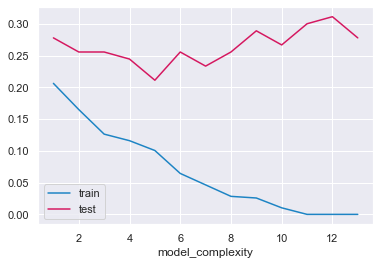

In [63]:
colors = ["#1D84C4", "#D51860", "#FACE63"]
sns.set(style="darkgrid")
sns.set_palette(sns.color_palette(colors))
complexity_df.plot(x='model_complexity')

In [64]:
# Export CSV selected features 
for i in range(0,k):
    X_train[i].to_csv(folder + '/' + fs + '_train_data_' + str(selection_method) + '_cv_' + str(cv) + '_' + str(i) + '.csv', index=False, encoding='utf-8-sig')
    X_test[i].to_csv(folder + '/' + fs + '_test_data_' + str(selection_method) + '_cv_' + str(cv) + '_' + str(i) + '.csv', index=False, encoding='utf-8-sig')